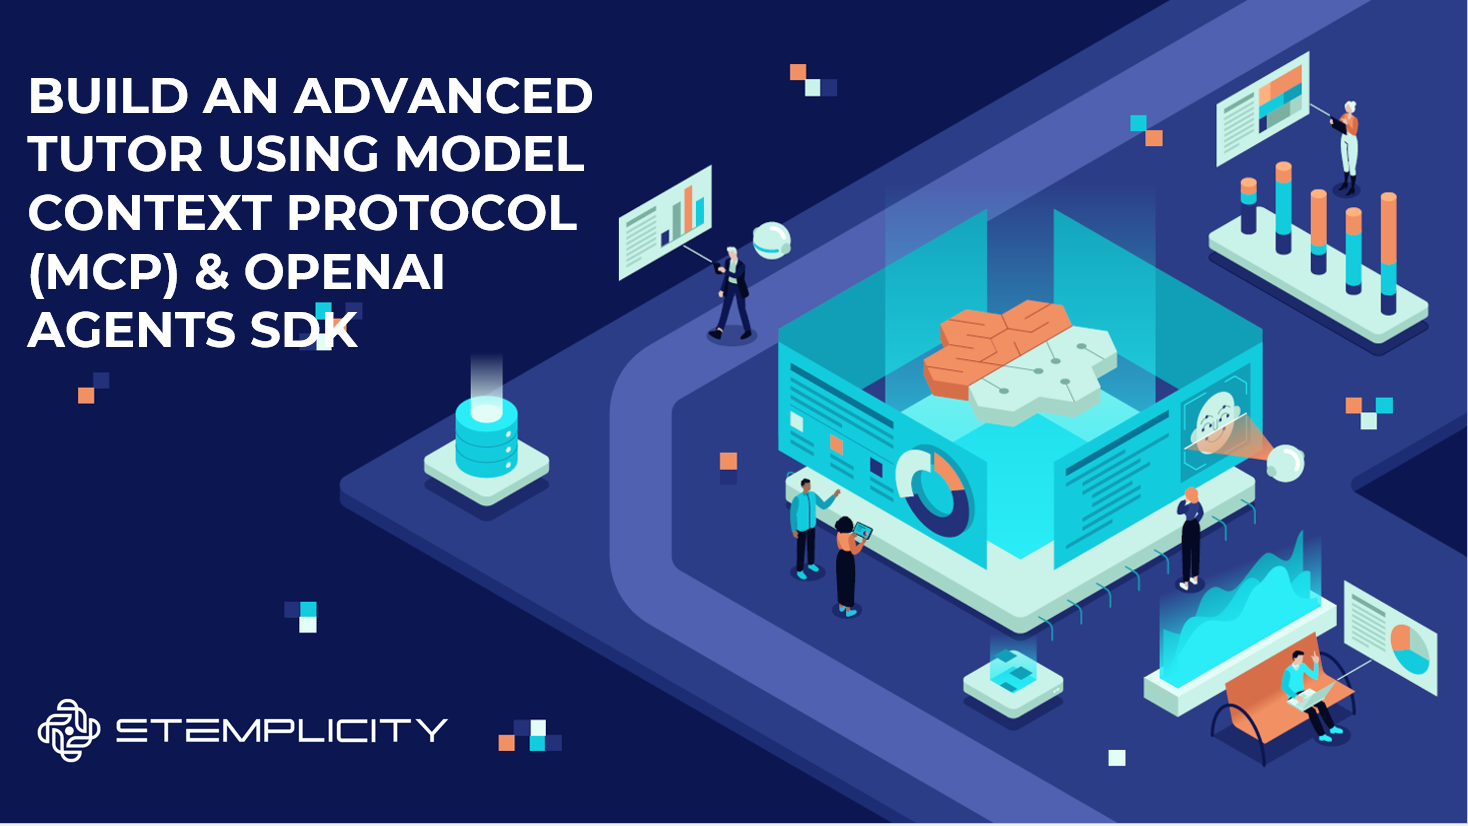

# TASK 1: PROJECT OVERVIEW 

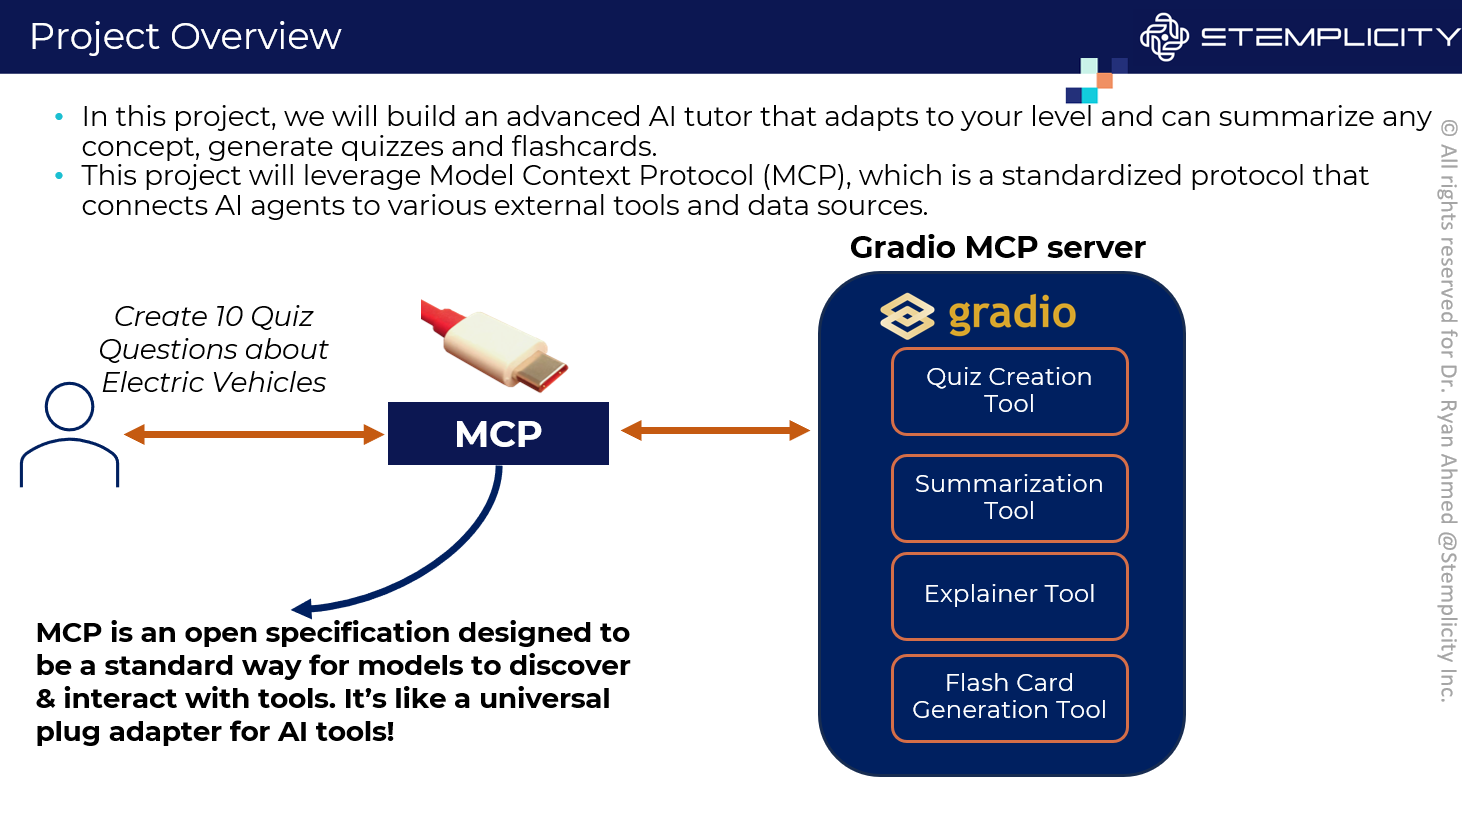



Welcome back! We've built chatbots, tutors, image processors, and even multi-agent systems. Now, let's explore how to make these creations available as **standardized tools** that other AI models or applications can easily use.

**The Problem:** How does an AI model (like a large language model) reliably use external functions or APIs? Traditionally, this required custom integrations ("plugins") for each specific tool.

**The Solution: Model-Context-Protocol (MCP)**
MCP is an open specification designed to be a **standard way for models to discover and interact with tools**. Imagine a universal plug adapter for AI tools! A model can ask an MCP-enabled service:
1.  "What tools do you offer?" (by fetching a standard description called a **manifest**)
2.  "Okay, please use tool X with these inputs." (by calling a standard **action** endpoint)

**Gradio makes it incredibly easy to expose your Python functions as MCP tools.**

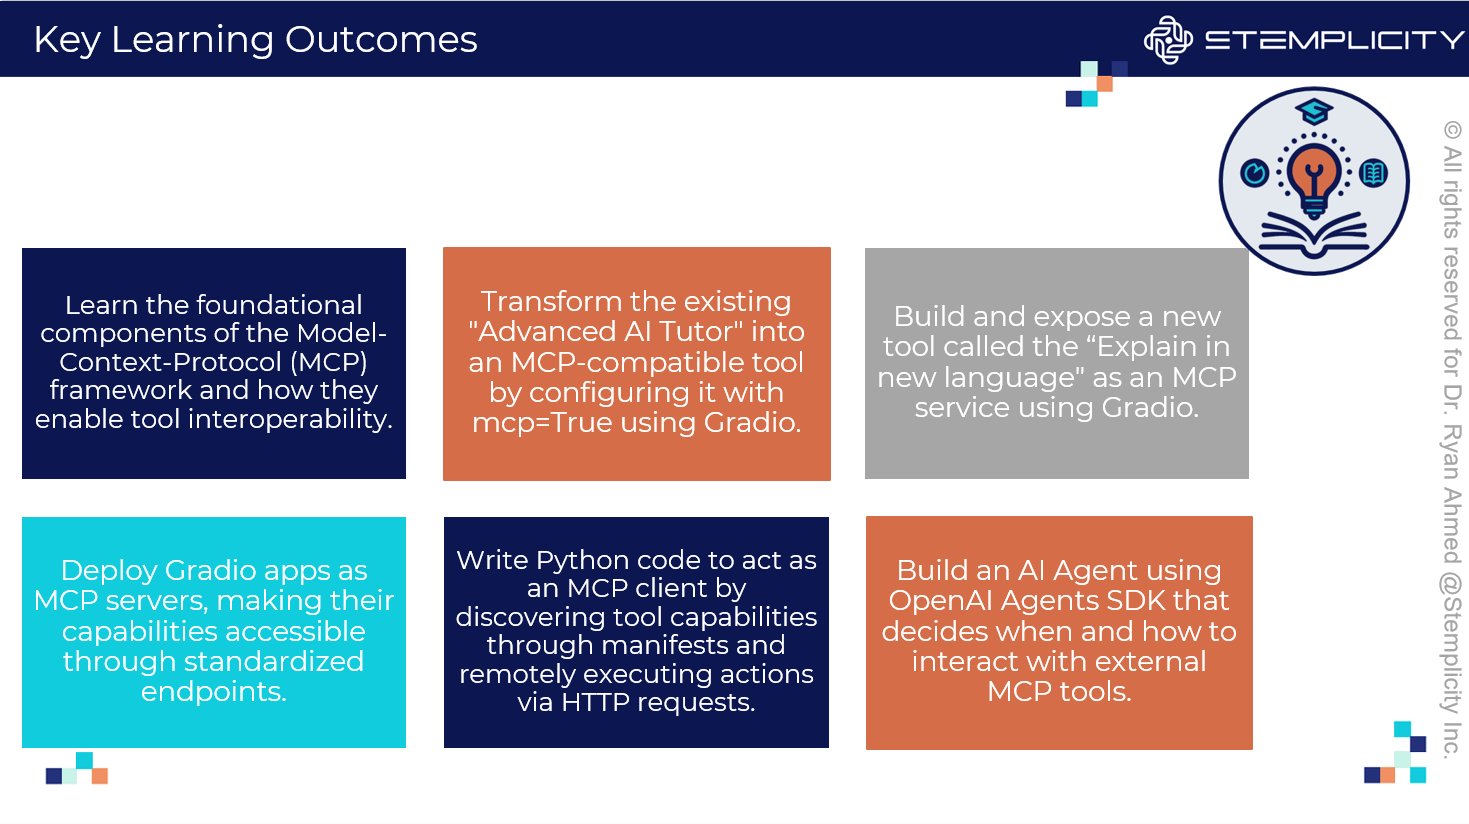

# TASK 2: UNDERSTANDING MCP (MODEL-CONTEXT-PROTOCOL)

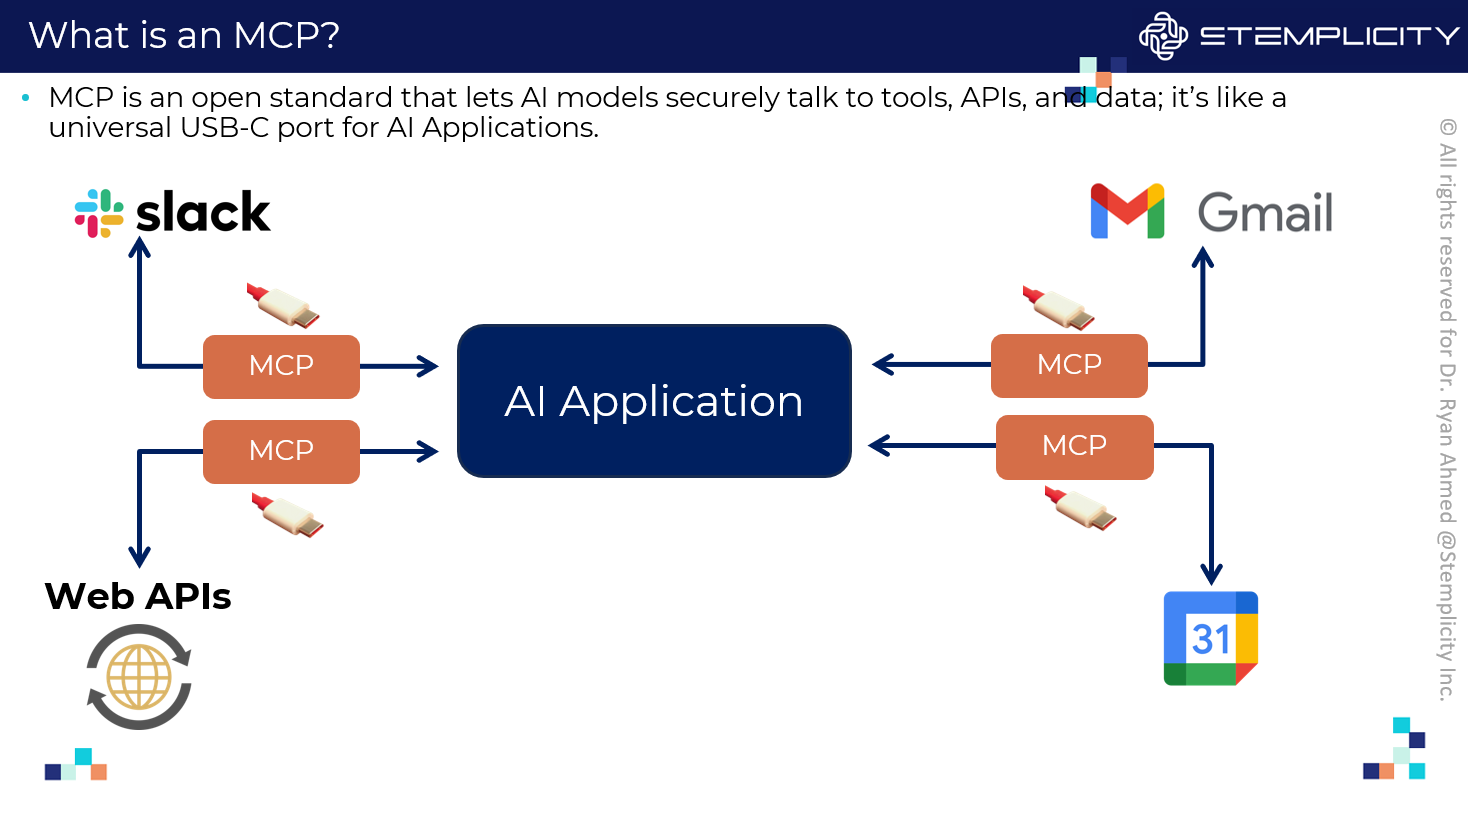

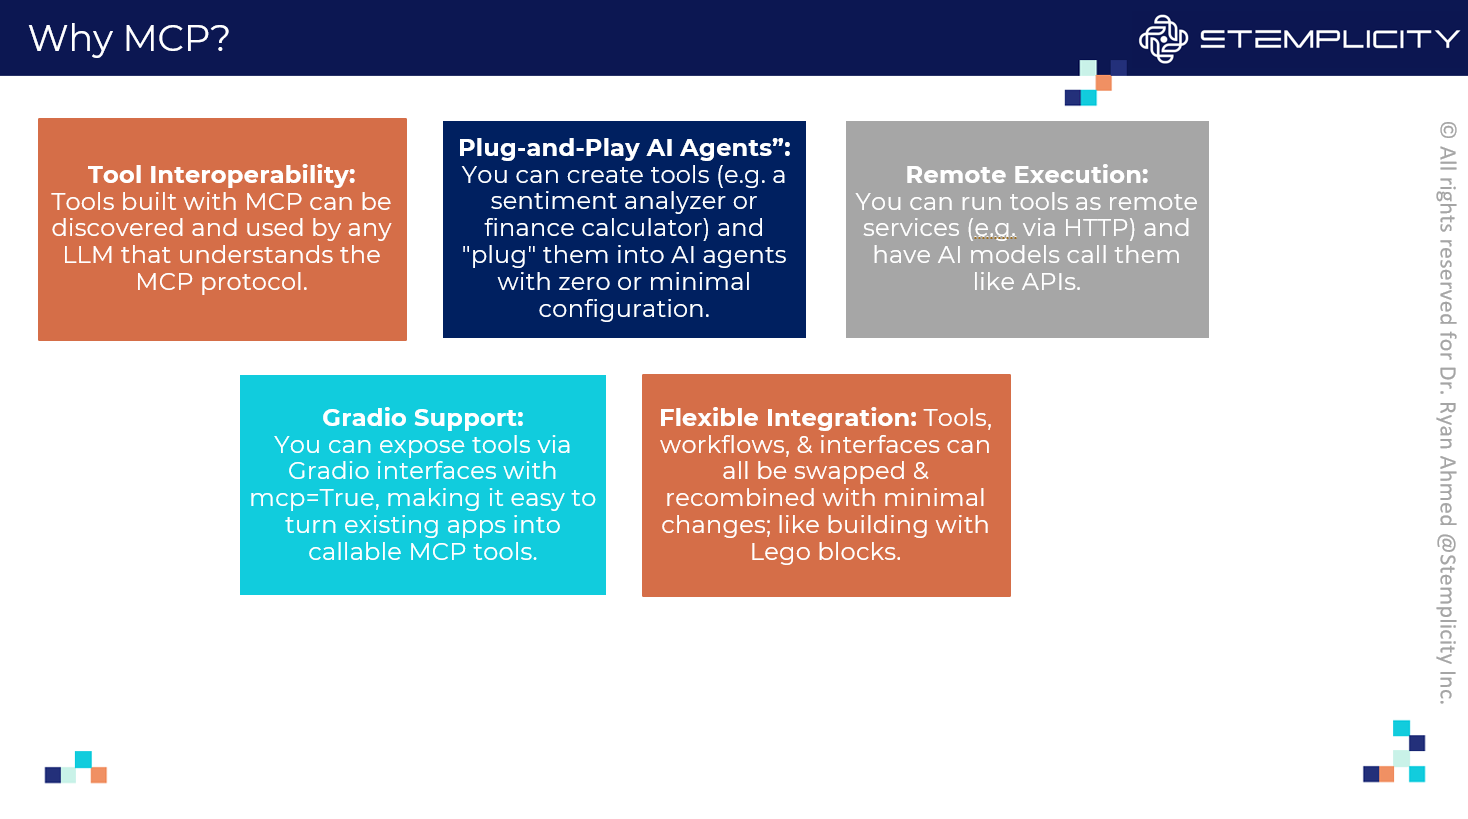

Before we code, let's clarify MCP. It standardizes how a **Model** (like an LLM) interacts with **Context** (external tools, APIs, functions).

**Key Components:**

1.  **MCP Server:** An application (like our Gradio app) that exposes one or more tools via MCP. It listens for requests on specific HTTP endpoints.
2.  **Manifest (`/mcp/manifest.json`):** A standard JSON file served by the MCP server. It describes the available tools (called "actions" in MCP terms):
    *   What each tool is called (`name`).
    *   What it does (`description`).
    *   What inputs it needs (`parameters`).
    *   What output it provides.
    *   Models use this manifest to **discover** tools and understand how to use them.
3.  **Action Endpoint (`/mcp/action`):** A standard endpoint on the MCP server where the model sends a request (usually a POST request) to execute a specific tool/action. The request includes the action name and the required parameters.

In this project, our Gradio apps will be the **MCP Servers**, and this notebook will act as the **MCP Client** (simulating a model wanting to use the tools).


# TASK 3: INSTALL KEY LIBRARIES & API KEYS



We'll need `gradio` to build the servers and `requests` (or `httpx`) in this notebook to act as the client. We also need `openai` and `python-dotenv` as our tools will use the OpenAI API.

Ensure your `.env` file has your OpenAI API key:
```dotenv
OPENAI_API_KEY=sk-YourSecretOpenAIKeyGoesHereXXXXXXXXXXXXX
```

In [ ]:
!pip install --upgrade openai-agents

In [ ]:
!pip install -q gradio openai python-dotenv requests httpx pillow

In [ ]:
# Import libraries for the notebook client
import os
import requests  # For making HTTP requests
import httpx  # An alternative async-friendly HTTP client (good practice)
import json  # For handling JSON data (manifests, action responses)
from dotenv import load_dotenv
from IPython.display import display, Markdown, Image  # To display results nicely
from openai import OpenAI  # or litellm, groq, etc.

from PIL import Image
import asyncio, pathlib

# Load environment variables (needed for the Gradio apps when they run)
load_dotenv()
openai_api_key = os.getenv("OPENAI_API_KEY")



In [ ]:
# Define a helper function to display markdown nicely 
def print_markdown(text):
    display(Markdown(text))

In [ ]:
# Let's define the URL where our Gradio MCP servers will be running
# IMPORTANT: Make sure these match the ports you use when running the server scripts!
MCP_BASE = "http://localhost:7860/gradio_api/mcp/sse"  # text tutor demo you built

# MCPServerSse: A class that sets up a server using Server-Sent Events (SSE) to serve MCP-compatible tools or agents.
# MCPServerSse allows your tool (e.g., an AI model wrapped with Gradio) to be served as an MCP tool endpoint.
# It allows Communication via SSE, which is a way to push updates from server to client (used in real-time AI applications).
from agents.mcp import MCPServerSse


# timeout: 30
# This controls how long (in seconds) the server waits for a single tool execution (i.e., an action call) before giving up.

# client_session_timeout_seconds: 60
# This sets how long an entire client session is kept alive without activity before it's considered expired or disconnected.
# If the client doesn’t send any requests or interact for 60 seconds, the session times out.

mcp_tool = MCPServerSse({
    "name": "AI Tutor",
    "url": MCP_BASE,
    "timeout": 30,
    "client_session_timeout_seconds":60
})


# TASK 4: BUILD & RUN THE MCP SERVER (MCP SERVER SETUP IS IN A SEPARATE NOTEBOOK)

Let's take our Advanced AI Tutor code and expose its core function as an MCP tool.

**The Key Change:** Adding `.launch(mcp=True)`

**Instructions:**
1. Open the `MCP Server.ipynb` and run it





**PRACTICE OPPORTUNITY:**
- **Add a new tool to the MCP server; this tool can explain a concept in different languages.**

# TASK 5: DISCOVER AVAILABLE TOOLS ON MCP SERVER & FETCH THE MANIFEST (SCHEMA)

- Our MCP server is running after succesfully running `MCP Server.ipynb` notebook. Now, from this notebook, let's act like a client wanting to see what tools they offer. 
- We do this by fetching the `/mcp/schema` endpoint using an HTTP GET request.


In [10]:
# This code is designed to fetch and display a schema (manifest) from an MCP server
# Typically used to describe available tools on that server.

# Let's use httpx for modern async-friendly requests (though requests works fine too)
client = httpx.Client()  # Create an HTTP client instance


def fetch_schema(server_url):
    """Fetches and parses the MCP schema from a server."""
    
    schema_url = server_url.replace("/sse", "/schema")
    print(f"Fetching schema from: {schema_url}")
    
    response = client.get(schema_url, timeout = 10)  # Add a timeout
    response.raise_for_status()  # Raise an exception for bad status codes (4xx or 5xx)
    schema_data = response.json()
    print("Schema fetched successfully!")
    return schema_data


In [11]:
# Fetch the manifest from the AI Tutor server

# Note that the schema is used by AI agents to know how to call the AI Tutor tool programmatically, ensuring the inputs match the required format.

print("--- Fetching AI Tutor Schema ---")
tutor_schema = fetch_schema(MCP_BASE)

if tutor_schema:
    print("\nAI Tutor Schema Contents:")
    # Pretty print the JSON manifest
    print(json.dumps(tutor_schema, indent=2))

print("\n" + "=" * 50 + "\n")  # Separator


--- Fetching AI Tutor Schema ---
Fetching schema from: http://localhost:7860/gradio_api/mcp/schema
Schema fetched successfully!

AI Tutor Schema Contents:
{
  "explain_concept": {
    "type": "object",
    "properties": {
      "question": {
        "type": "string"
      },
      "level": {
        "type": "number",
        "description": "numeric value between 1 and 5"
      }
    },
    "description": "Stream an explanation of *question* at the requested *level* (1\u20115). If 1, explanation would be like we are talking to a 5 year old and if 5, explanation would be technical and complex."
  },
  "summarize_text": {
    "type": "object",
    "properties": {
      "text": {
        "type": "string"
      },
      "compression_ratio": {
        "type": "number",
        "description": "numeric value between 0.1 and 0.8"
      }
    },
    "description": "Stream a summary of *text* compressed to roughly *compression_ratio* length. *compression_ratio* should be between 0.1 and 0.8."
  }

**PRACTICE OPPORTUNITY:**
- **Stop the Gradio servers and edit its notebook file (`MCP Server.ipynb`).**
- **Improve the docstring of the core function (`explain_concept`) to be more descriptive for an LLM. For example, add details about in what level of detail the tool will explain the concept.**
- **Restart the Gradio server and re-run the notebook cell above that fetches the schema. Has it updated with your improved text?**

# TASK 6: CREATE AN AI AGENT USING OPENAI AGENTS SDK THAT USES MCP TOOLS  

The OpenAI Agents SDK enables you to build agentic AI apps in a lightweight, easy-to-use package with very few abstractions. The Agents SDK has a very small set of primitives:

- Agents, which are LLMs equipped with instructions and tools
- Handoffs, which allow agents to delegate to other agents for specific tasks
- Guardrails, which enable the inputs to agents to be validated
  
In combination with Python, these primitives are powerful enough to express complex relationships between tools and agents, and allow you to build real-world applications without a steep learning curve.
- Link: https://openai.github.io/openai-agents-python/

In [12]:
# Let's Build the AI agent
from agents import Agent, Runner

agent = Agent(
    name = "Smart Assistant",
    instructions = """
    Context
    -------
    You are an AI assistant with access to an MCP server exposing **four streaming tools**:

    1. **explain_concept**  
    Arguments: { "question": <str>, "level": <int 1‑5> }  
    • Streams an explanation of any concept at the requested depth.

    2. **summarize_text**  
    Arguments: { "text": <str>, "compression_ratio": <float 0.1‑0.8> }  
    • Streams a concise summary ~compression_ratio × original length.

    3. **generate_flashcards**  
    Arguments: { "topic": <str>, "num_cards": <int 1‑20> }  
    • Streams JSON‑lines flashcards: one card per line `{ "q":…, "a":… }`.

    4. **quiz_me**  
    Arguments: { "topic": <str>, "level": <int 1‑5>, "num_questions": <int 1‑15> }  
    • Streams an MC‑question quiz, then an ANSWER KEY section.

    Objective
    ---------
    Help users learn by:
    • Explaining concepts at the depth they request.  
    • Summarising long passages.  
    • Generating flashcards for self‑study.  
    • Quizzing them interactively.

    How to respond
    --------------
    • For each user request, decide which tool (if any) fulfils it best.  
    • Call the tool via MCP by returning *only* the JSON with `"tool"` and `"arguments"` (no extra text).  
    • If a follow‑up conversation is needed (e.g., clarification), ask the user first.  
    • If no tool fits, answer directly in plain language.

    Examples
    --------
    User: “Explain quantum tunnelling like I’m 10.”  
    → Call `explain_concept` with { "question": "quantum tunnelling", "level": 2 }

    User: “Summarise this article to 20 %.” + <article text>  
    → Call `summarize_text` with { "text": "...", "compression_ratio": 0.2 }

    Chat capability
    ---------------
    After each tool call completes (streaming back to the user), remain in the chat loop ready for the next user turn.
    """,
    model = "gpt-4o-mini",
    mcp_servers = [mcp_tool],
)

In [13]:
# This code snippet is implementing a conversational loop with an AI agent that uses MCP tools.

# Opens a connection with an MCP tool. 
# This lets our AI agent interact with an external tool (e.g., image generator, calculator, etc.) over a standard protocol using SSE (Server-Sent Events).
await mcp_tool.connect()  # open SSE channels

result = None
while True:
    user_input = input("User: ")
    if user_input.lower() in {"exit", "quit"}:
        break
        
    # If there was a previous interaction (result is not None), it appends the new user message to the past messages (maintaining conversation context).
    if result is not None:
        new_input = result.to_input_list() + [{"role": "user", "content": user_input}]
    else:
        new_input = [{"role": "user", "content": user_input}]
    print("\nUser Input:")
    print_markdown(user_input)

    
   # This is the core AI agent execution step. It runs your agent with the new_input.

    result = await Runner.run(starting_agent = agent, input = new_input)
    print("\nAssistant:")
    print_markdown(result.final_output)

User:  explain how iphone works in a simple term 



User Input:


explain how iphone works in a simple term 


Assistant:


The iPhone is like a tiny computer in your pocket. It has a screen, buttons, and a battery. You can touch the screen to open apps, talk to your friends, take pictures, and play games. It connects to the internet to help you find information and share things. Inside, it has parts that help it think (like a brain) and parts that help it remember things (like memory).

User:  generate a list of 10 questions as part of a quiz



User Input:


generate a list of 10 questions as part of a quiz


Assistant:


Here are 10 questions for the quiz on iPhones:

1. What is the name of the app store on iPhones?
2. What is the main button on the front of the iPhone called?
3. Which company makes the iPhone?
4. What do you use to unlock an iPhone?
5. What can you do with the camera on an iPhone?
6. What is Siri?
7. How can you charge an iPhone?
8. What does Wi-Fi do for your iPhone?
9. What is the iPhone's operating system called?
10. What feature allows you to talk to someone using voice commands?

Would you like to see the answers to these questions?

User:  exit


In [14]:
# Let's view the list of tools that have been called
for i in result.to_input_list():
    for key in i.keys():
        if key == 'arguments':
            print("Tool: ", i['name'])
            print("Arguments: ", i['arguments'])


Tool:  explain_concept
Arguments:  {"question":"how iPhone works","level":2}
Tool:  explain_concept
Arguments:  {"question":"how iPhone works","level":1}
Tool:  quiz_me
Arguments:  {"topic":"iPhone","level":1,"num_questions":10}


# PRACTICE OPPORTUNITIES SOLUTIONS

**PRACTICE OPPORTUNITY SOLUTION:**
- **Add a new tool to the MCP server; this tool can explain a concept in different languages.**

In [ ]:
def explain_concept_in_language(question: str, level: int, language: str) -> Generator[str, None, None]:
    """Stream an explanation of *question* at the requested *level* (1‑5) in the specified *language*. 
    Need: question, level, language"""

    if not question.strip():
        yield "Error: question cannot be blank."
        return

    level_desc = EXPLANATION_LEVELS.get(level, "clearly and concisely")
    system_prompt = "You are a helpful AI Tutor. Explain the following concept " f"{level_desc} in the following language: {language}"
    _stream = client.chat.completions.create(
        model = MODEL_NAME,
        messages = [
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question},
        ],
        stream = True,
        temperature =0.7,
    ) 
    partial = ""
    for chunk in _stream:
        delta = getattr(chunk.choices[0].delta, "content", None)
        if delta:
            partial += delta
            yield partial


In [ ]:


def build_demo():
    with gr.Blocks() as demo:
        gr.Markdown("# AI Tutor MCP Toolkit – Demo Console")
        with gr.Tab("Explain Concept"):
            q = gr.Textbox(label = "Concept / Question")
            lvl = gr.Slider(1, 5, value = 3, step = 1, label = "Explanation Level")
            out1 = gr.Markdown()
            gr.Button("Explain").click(explain_concept, inputs = [q, lvl], outputs = out1)
        with gr.Tab("Explain Concept in Language"):
            q = gr.Textbox(label = "Concept / Question")
            lvl = gr.Slider(1, 5, value = 3, step = 1, label = "Explanation Level")
            lang = gr.Textbox(label = "Language")
            out2 = gr.Markdown()
            gr.Button("Explain").click(explain_concept_in_language, inputs = [q, lvl, lang], outputs = out2)
        with gr.Tab("Summarize Text"):
            txt = gr.Textbox(lines = 8, label = "Long Text")
            ratio = gr.Slider(0.1, 0.8, value = 0.3, step = 0.05, label = "Compression Ratio")
            out3 = gr.Markdown()
            gr.Button("Summarize").click(summarize_text, inputs=[txt, ratio], outputs = out3)
        with gr.Tab("Flashcards"):
            topic_fc = gr.Textbox(label = "Topic")
            n_fc = gr.Slider(1, 20, value = 5, step = 1, label = "# Cards")
            out4 = gr.Markdown()
            gr.Button("Generate").click(generate_flashcards, inputs = [topic_fc, n_fc], outputs = out4)
        with gr.Tab("Quiz Me"):
            topic_q = gr.Textbox(label = "Topic")
            lvl_q = gr.Slider(1, 5, value = 3, step = 1, label = "Difficulty Level")
            n_q = gr.Slider(1, 15, value = 5, step = 1, label = "# Questions")
            out5 = gr.Markdown()
            gr.Button("Start Quiz").click(quiz_me, inputs = [topic_q, lvl_q, n_q], outputs = out5)
    return demo


if __name__ == "__main__":
    print("Starting AI Tutor MCP Toolkit on port 7860…")
    build_demo().launch(server_name = "0.0.0.0", mcp_server = True)



**PRACTICE OPPORTUNITY SOLUTION:**
- **Stop the Gradio servers and edit its notebook file (`MCP Server.ipynb`).**
- **Improve the docstring of the core function (`explain_concept`) to be more descriptive for an LLM. For example, add details about in what level of detail the tool will explain the concept.**
- **Restart the Gradio server and re-run the notebook cell above that fetches the schema. Has it updated with your improved text?**

In [ ]:
# In the MCP Server.ipynb file, update the docstring as shown below

def explain_concept(question: str, level: int) -> Generator[str, None, None]:
    """Stream an explanation of *question* at the requested *level* (1‑5). If 1, explanation would be like we are talking to a 5 year old and if 5, explanation would be technical and complex."""
    if not question.strip():
        yield "Error: question cannot be blank."
        return

    level_desc = EXPLANATION_LEVELS.get(level, "clearly and concisely")
    system_prompt = "You are a helpful AI Tutor. Explain the following concept " f"{level_desc}."
    _stream = client.chat.completions.create(
        model=MODEL_NAME,
        messages=[
            {"role": "system", "content": system_prompt},
            {"role": "user", "content": question},
        ],
        stream=True,
        temperature=0.7,
    )
    partial = ""
    for chunk in _stream:
        delta = getattr(chunk.choices[0].delta, "content", None)
        if delta:
            partial += delta
            yield partial

**Original Schema:**

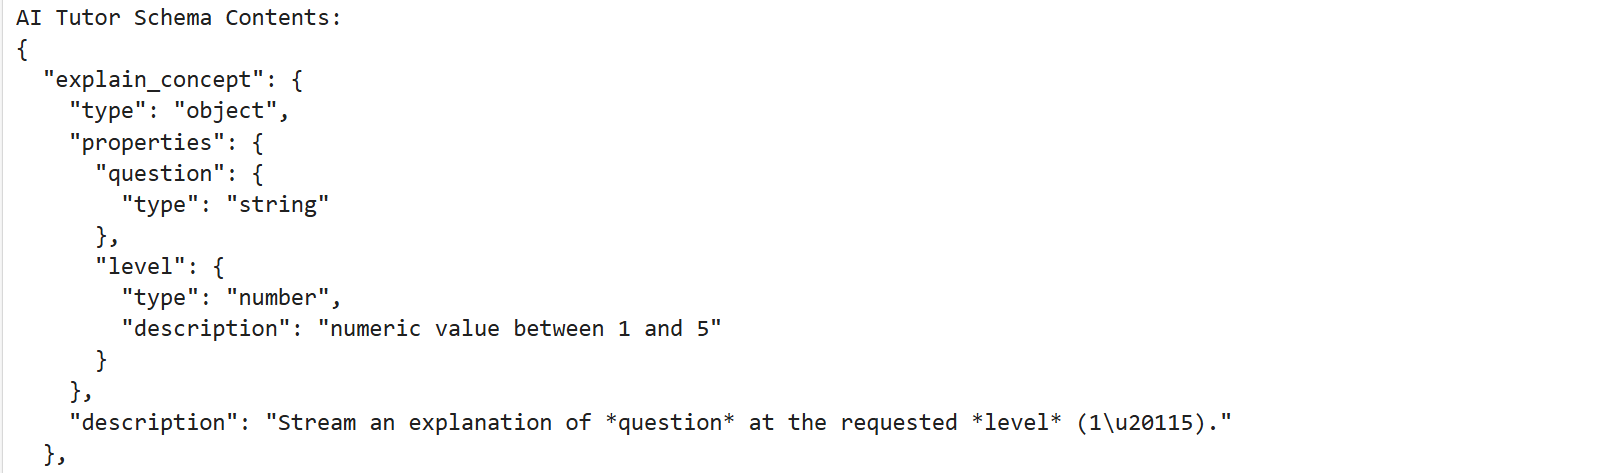

**New Schema:**

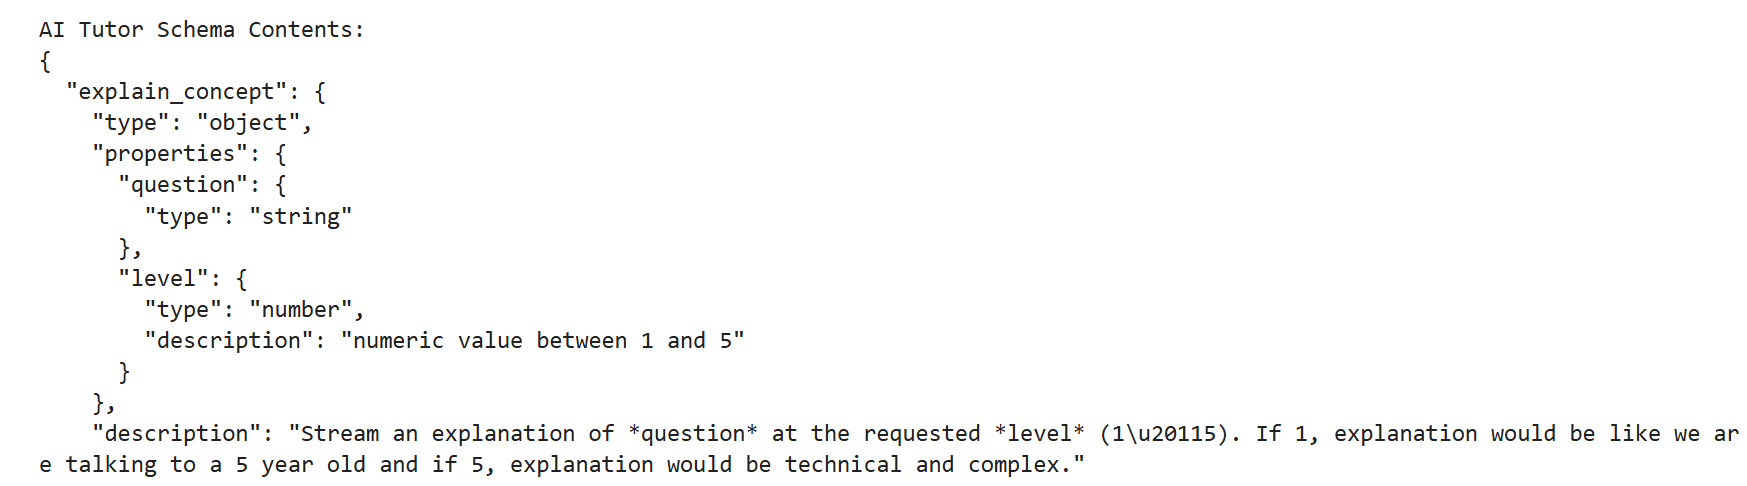

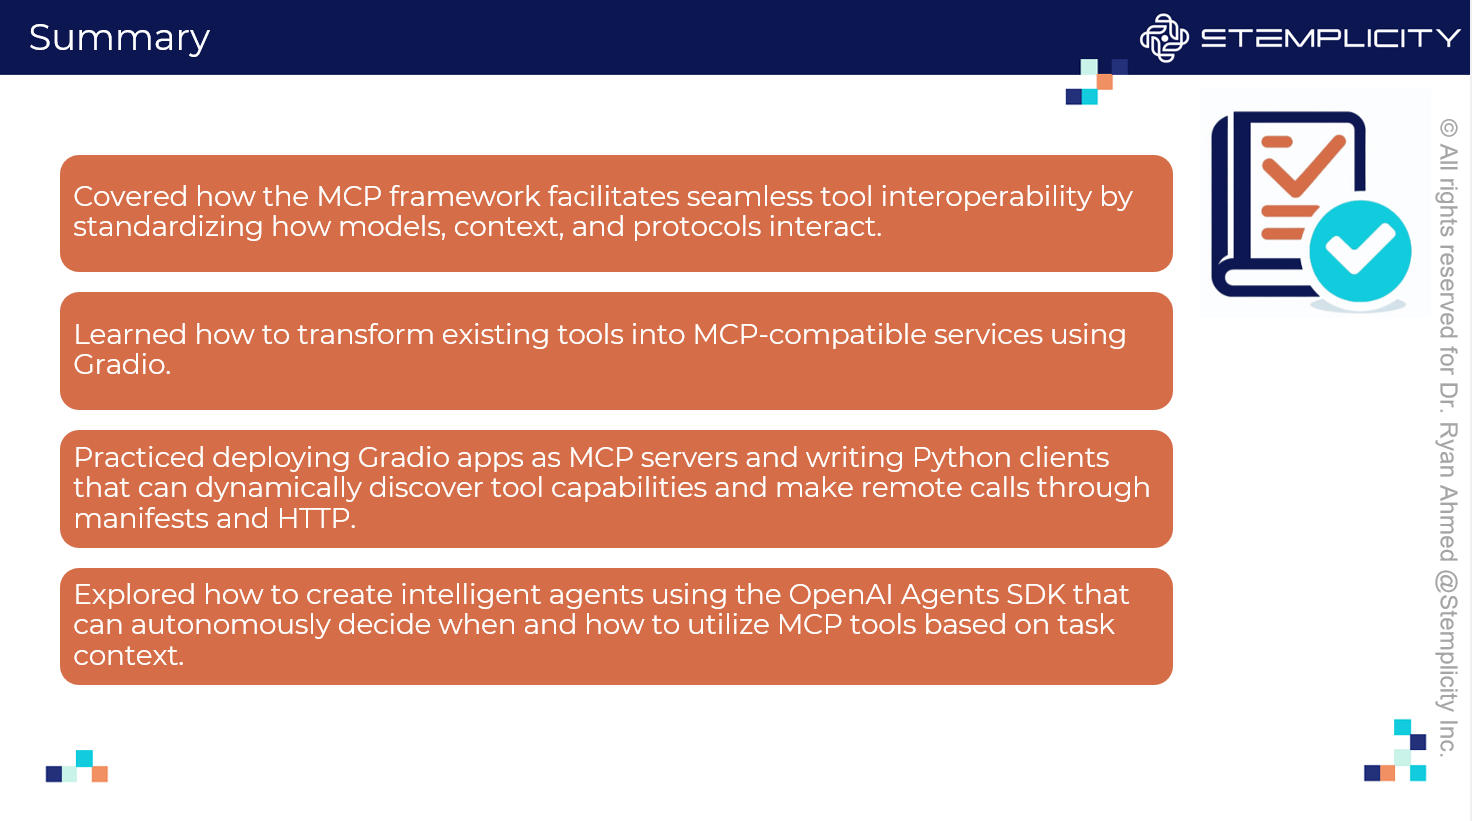

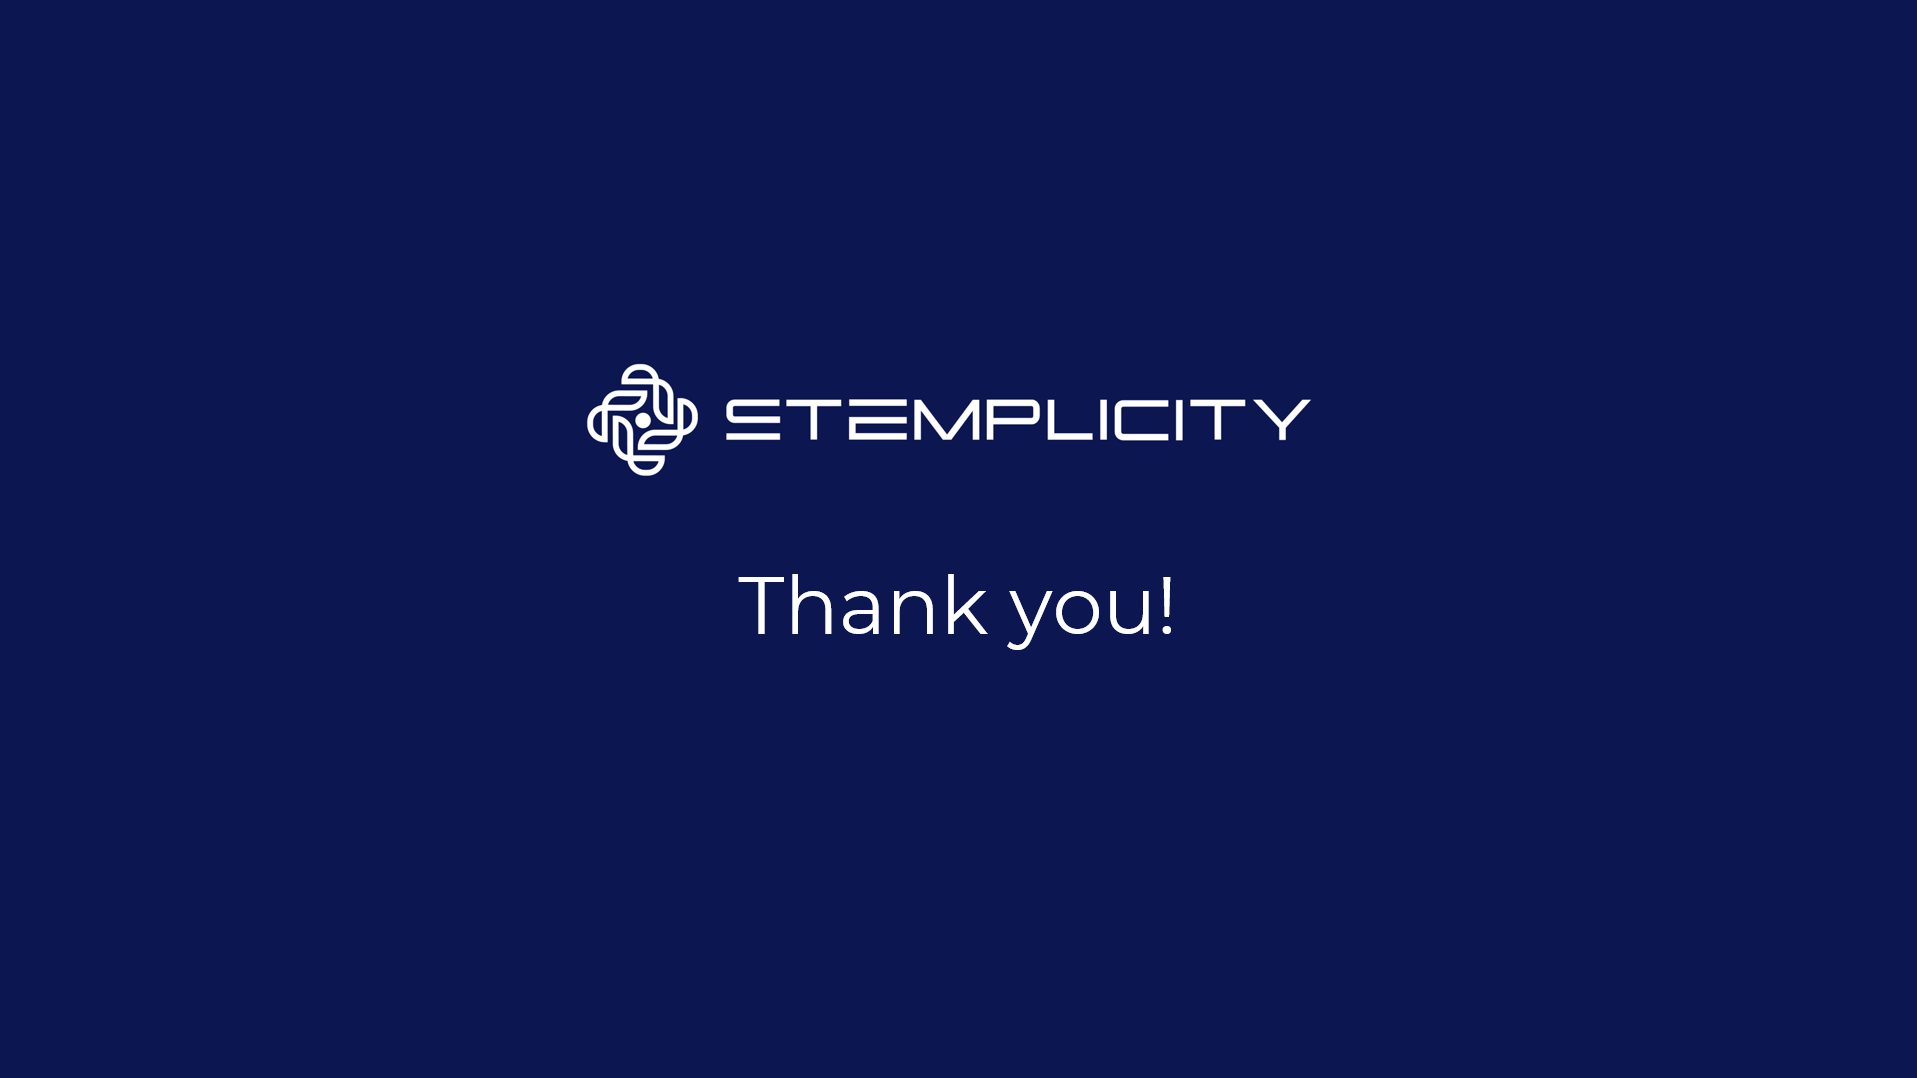